<h1><center> PROJECT - COMPUTER VISION AND DEEP LEARNING </center></h1>

<i>By Antonin PAOLI (VR511432) - Master 1 student at the ENSIMAG school in Grenoble, France</i>

## PART 1 - INITIALIZATION
---

### Importing libraries useful for our project

In [1]:
import os
import torch
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import math
import cv2
from PIL import Image
import numpy as np

### List of hyperparameters (Can be changed if necessary)

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
NB_EPOCHS = 5
BATCH_SIZE = 64
LR = 0.001
TRAIN_RATIO = 0.7
DATASET_LINK = "./dataset"
NEW_DATASET_LINK = "./new_dataset"
STRATEGY_DS = 0
NB_CLASSES = len(os.listdir(DATASET_LINK))
PRECISION_EARLY_STOP = 0.005

## PART 2 - DATASET ANALYSIS
---

### Function Name: `dataset_analysis`

#### Description
Retrieves a number of metrics from the dataset for analysis.

#### Parameters
- **dataset_dir** (`string`): The path of the dataset to be analysed

#### Returns
- **nb_of_images_per_class** (`list of int`): The number of images for each class
- **label_per_class** (`list of string`): The name for each class
- **random_image_per_class** (`list of string`): The path of a random image of each class


In [3]:
def dataset_analysis(dataset_dir):
    nb_of_images_per_class = [0] * NB_CLASSES
    label_per_class = [""] * NB_CLASSES
    random_image_per_class = [""] * NB_CLASSES
    
    for i, cl in enumerate(os.listdir(dataset_dir)):
        label_per_class[i] = cl
        class_dir = os.path.join(dataset_dir, cl)
        nb_of_images_per_class[i] = len(os.listdir(class_dir))
        list_images = [os.path.join(class_dir, image) for image in os.listdir(class_dir)]
        random_image_per_class[i] = random.choice(list_images)
        
    return nb_of_images_per_class, label_per_class, random_image_per_class

In [4]:
nb_of_images_per_class, label_per_class, random_image_per_class = dataset_analysis(DATASET_LINK)

### Display graphics for previously recovered metrics

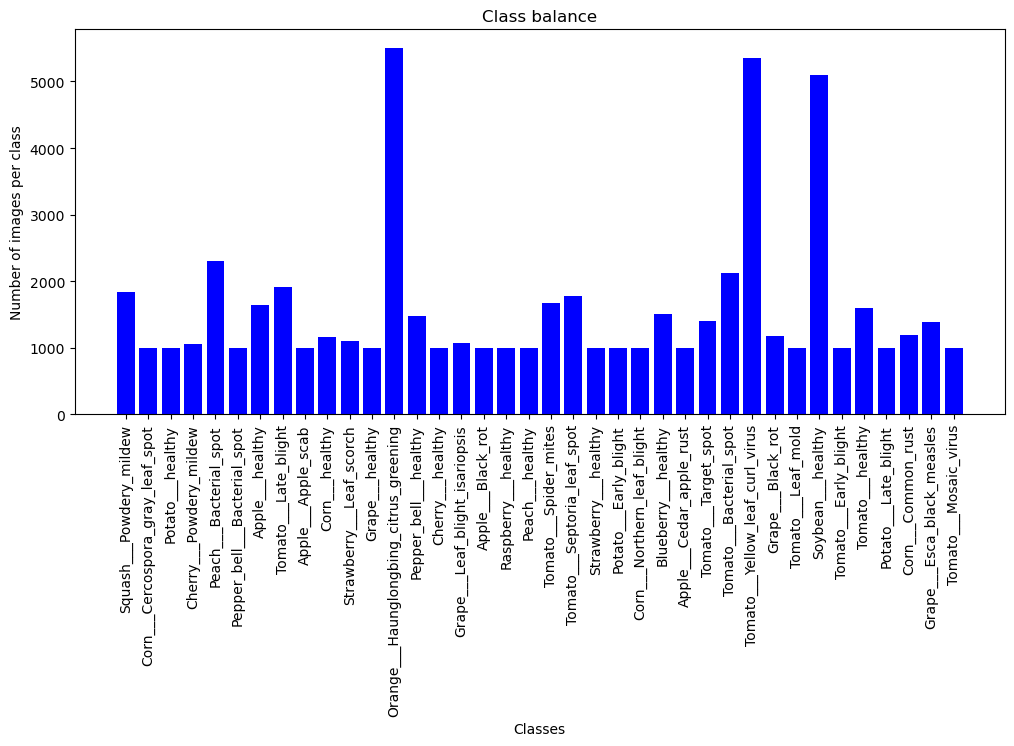

In [5]:
plt.figure(figsize=(12,5))
plt.title('Class balance')
plt.xlabel('Classes')
plt.ylabel('Number of images per class')
plt.bar(label_per_class, nb_of_images_per_class, color='blue')
plt.xticks(rotation=90)
plt.show()

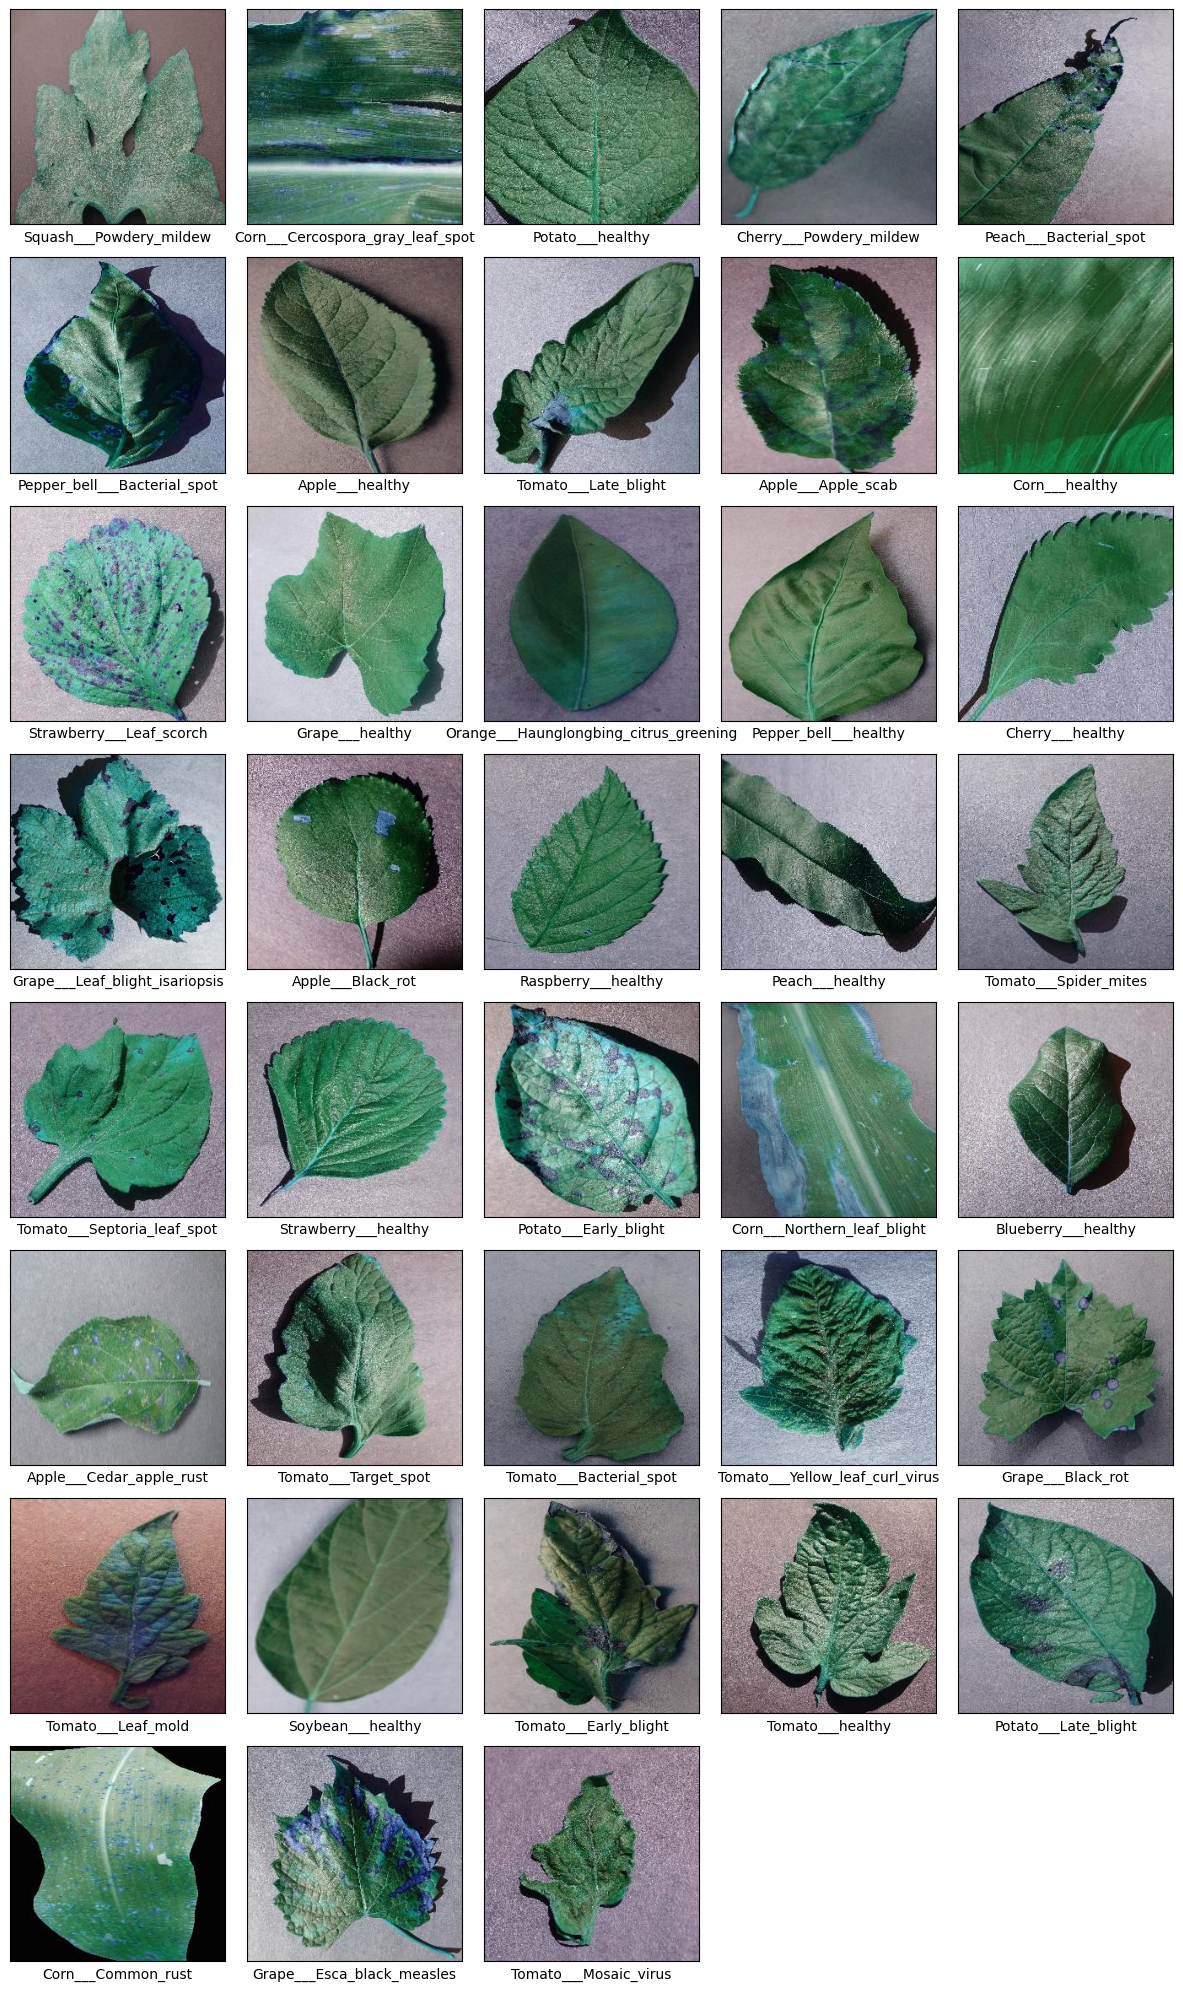

In [6]:
cols = 5
rows = math.ceil(NB_CLASSES / cols)

plt.figure(figsize=(12, 20))

for i in range(NB_CLASSES):
    plt_sub = plt.subplot(rows, cols, i + 1)
    image = cv2.imread(random_image_per_class[i])
    plt.imshow(image)
    plt.xlabel(label_per_class[i])
    plt_sub.set_xticks([])
    plt_sub.set_yticks([])

plt.tight_layout()
plt.show()

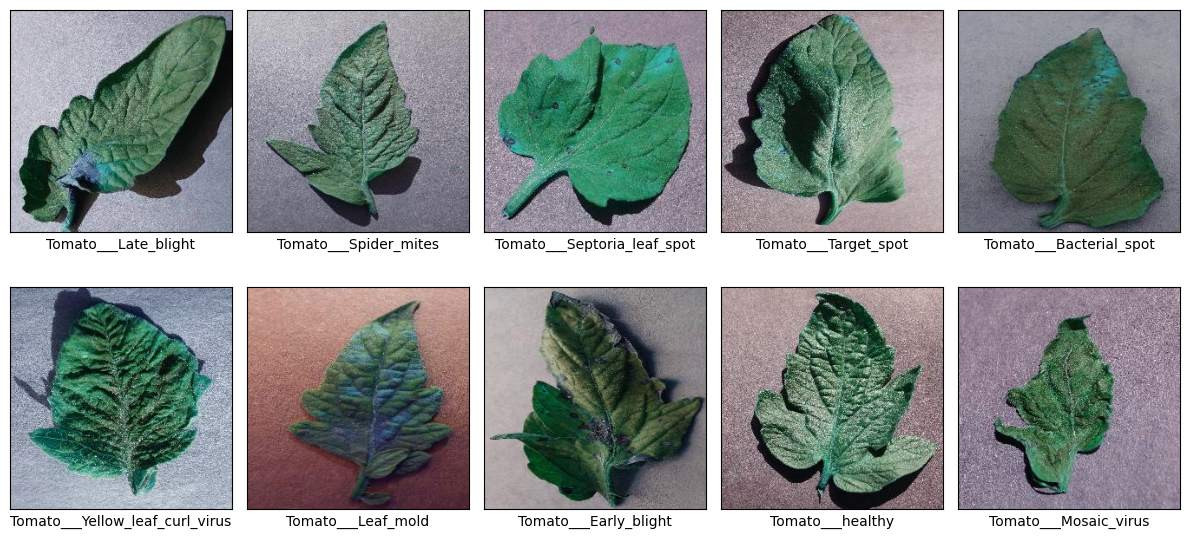

In [7]:
cols = 5
rows = 2
incr = 1

plt.figure(figsize=(12, 6))

for i in range(NB_CLASSES):
    if "Tomato" in random_image_per_class[i]:
        plt_sub = plt.subplot(rows, cols, incr)
        image = cv2.imread(random_image_per_class[i])
        plt.imshow(image)
        plt.xlabel(label_per_class[i])
        plt_sub.set_xticks([])
        plt_sub.set_yticks([])
        incr += 1

plt.tight_layout()
plt.show()

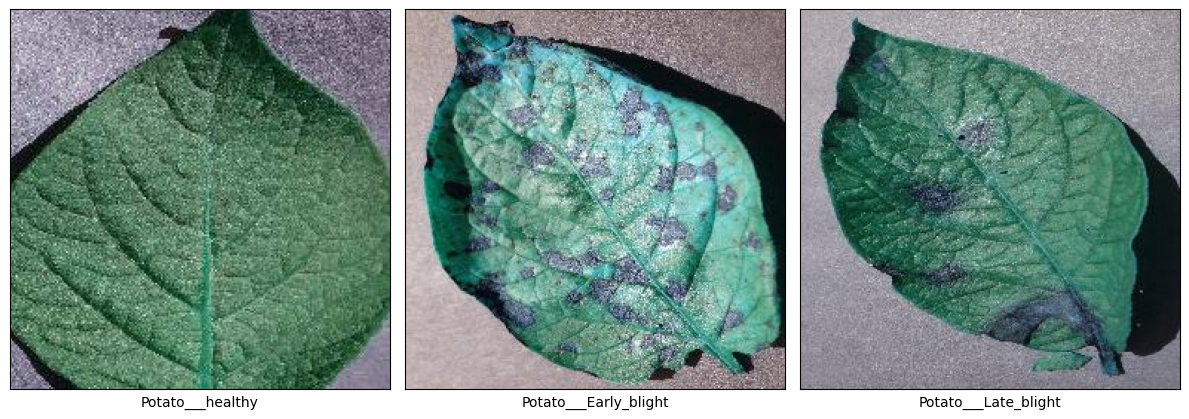

In [8]:
cols = 3
rows = 1
incr = 1

plt.figure(figsize=(12, 6))

for i in range(NB_CLASSES):
    if "Potato" in random_image_per_class[i]:
        plt_sub = plt.subplot(rows, cols, incr)
        image = cv2.imread(random_image_per_class[i])
        plt.imshow(image)
        plt.xlabel(label_per_class[i])
        plt_sub.set_xticks([])
        plt_sub.set_yticks([])
        incr += 1

plt.tight_layout()
plt.show()

## PART 3 - SEPARATING THE DATASET INTO SEVERAL SETS
---

### Function Name: `get_nb_images_min`

#### Description
Returns the number of images in the least represented class of the dataset

#### Parameters
- **dataset_dir** (`string`): The path of the dataset to be analysed

#### Returns
- **nb_min** (`int`): The minimum number of images

In [9]:
def get_nb_images_min(dataset_dir):
    nb_min = float('inf')
    for cl in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, cl)
        nb_images_class = len([os.path.join(class_dir, image) for image in os.listdir(class_dir)])
        if nb_min > nb_images_class:
            nb_min = nb_images_class
    return nb_min

### Function Name: `background_removal`

#### Description
Transforms any background that does not represent the leaf into a black pixel

#### Parameters
- **image_path** (`string`): The path of the image to be transformed

#### Returns
- **segmented_leaf** (`numpy array`): The segmented image with a black background

In [10]:
def background_removal(image_path):
    image = cv2.imread(image_path)

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    lower_green = np.array([0, 0, 0])
    upper_green = np.array([85, 255, 255])
    mask = cv2.inRange(hsv, lower_green, upper_green)
    
    kernel = np.ones((3, 3), np.uint8)
    mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    max_contour = max(contours, key=cv2.contourArea)

    mask_final = np.zeros_like(mask_cleaned)
    cv2.drawContours(mask_final, [max_contour], -1, 255, thickness=cv2.FILLED)

    segmented_leaf = cv2.bitwise_and(image, image, mask=mask_final)

    return segmented_leaf

### Function Name: `split_dataset`

#### Description
Divides the dataset into 3 sets (train, valid and test). Applies the leaf segmentation if the strategy is equal to 1, otherwise the image remains unchanged

#### Parameters
- **dataset_in** (`string`): The path of the initial dataset
- **dataset_out** (`string`): The path to the newly created dataset
- **train_ratio** (`float in [0, 1]`): The percentage of images per class that will go into the training set
- **ref_balance_of_classes** (`int`): The number of images of the least represented class for class balance
- **strategy** (`int in {0, 1}`): 0 corresponds to a conventional copy of the images. 1 corresponds to a copy of the image with segmentation

In [11]:
def split_dataset(dataset_in, dataset_out, train_ratio, ref_balance_of_classes, strategy):

    # Create the directory
    os.makedirs(dataset_out, exist_ok=True)
    train_dir = os.path.join(dataset_out, 'train')
    os.makedirs(train_dir, exist_ok=True)
    valid_dir = os.path.join(dataset_out, 'valid')
    os.makedirs(valid_dir, exist_ok=True)
    test_dir = os.path.join(dataset_out, 'test')
    os.makedirs(test_dir, exist_ok=True)

    for cl in os.listdir(dataset_in):
        print(f'Processing for class {cl}...')
        class_dir = os.path.join(dataset_in, cl)
        train_class_dir = os.path.join(train_dir, cl)
        os.makedirs(train_class_dir, exist_ok=True)
        valid_class_dir = os.path.join(valid_dir, cl)
        os.makedirs(valid_class_dir, exist_ok=True)
        test_class_dir = os.path.join(test_dir, cl)
        os.makedirs(test_class_dir, exist_ok=True)

        list_images = [os.path.join(class_dir, image) for image in os.listdir(class_dir)]
        train_list_images, valid_test_list_images = train_test_split(list_images, train_size = (ref_balance_of_classes / len(list_images) * train_ratio))
        valid_list_images, test_list_images = train_test_split(valid_test_list_images, train_size = 0.5)

        for i, image_path in enumerate(train_list_images):
            if strategy == 0:
                shutil.copy(image_path, os.path.join(train_class_dir, f"image{i}.png"))
            else:
                image = background_removal(image_path)
                if image is None:
                    continue
                else:
                    cv2.imwrite(os.path.join(train_class_dir, f"image{i}.png"), image)
        print(f'  -> Number of train images : {len(train_list_images)}')
        
        for i, image_path in enumerate(valid_list_images):
            if strategy == 0:
                shutil.copy(image_path, os.path.join(valid_class_dir, f"image{i}.png"))
            else:
                image = background_removal(image_path)
                if image is None:
                    continue
                else:
                    cv2.imwrite(os.path.join(valid_class_dir, f"image{i}.png"), image)
        print(f'  -> Number of valid images : {len(valid_list_images)}')
        
        for i, image_path in enumerate(test_list_images):
            if strategy == 0:
                shutil.copy(image_path, os.path.join(test_class_dir, f"image{i}.png"))
            else:
                image = background_removal(image_path)
                if image is None:
                    continue
                else:
                    cv2.imwrite(os.path.join(test_class_dir, f"image{i}.png"), image)
        print(f'  -> Number of test images : {len(test_list_images)}')
        print("\n")

In [12]:
split_dataset(DATASET_LINK, NEW_DATASET_LINK, TRAIN_RATIO, get_nb_images_min(DATASET_LINK), STRATEGY_DS)

Processing for class Squash___Powdery_mildew...
  -> Number of train images : 700
  -> Number of valid images : 567
  -> Number of test images : 568


Processing for class Corn___Cercospora_gray_leaf_spot...
  -> Number of train images : 700
  -> Number of valid images : 150
  -> Number of test images : 150


Processing for class Potato___healthy...
  -> Number of train images : 700
  -> Number of valid images : 150
  -> Number of test images : 150


Processing for class Cherry___Powdery_mildew...
  -> Number of train images : 700
  -> Number of valid images : 176
  -> Number of test images : 176


Processing for class Peach___Bacterial_spot...
  -> Number of train images : 700
  -> Number of valid images : 798
  -> Number of test images : 799


Processing for class Pepper_bell___Bacterial_spot...
  -> Number of train images : 700
  -> Number of valid images : 150
  -> Number of test images : 150


Processing for class Apple___healthy...
  -> Number of train images : 699
  -> Number of

## PART 4 - PREPROCESSING
---

In [13]:
#Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#Datasets
data_sets = {
    'train': ImageFolder(root=f'{NEW_DATASET_LINK}/train', transform=data_transforms['train']),
    'valid': ImageFolder(root=f'{NEW_DATASET_LINK}/valid', transform=data_transforms['test']),
    'test': ImageFolder(root=f'{NEW_DATASET_LINK}/test', transform=data_transforms['test'])
}

#Dataloaders
data_loaders = {
    'train': DataLoader(data_sets['train'], batch_size=BATCH_SIZE, shuffle=True),
    'valid': DataLoader(data_sets['valid'], batch_size=BATCH_SIZE, shuffle=True),
    'test': DataLoader(data_sets['test'], batch_size=BATCH_SIZE, shuffle=True)
}

## PART 5 - TRAINING - EVALUATION - TESTING
---

### Function Name: `train_model`

#### Description
Trains our model on the training set with descent of the gradient and calculation of our loss function.

#### Parameters
- **model** (`torchvision.models.ResNet`) : The model
- **criterion** (`torch.nn.modules.loss`) : The loss function
- **optimizer** (`torch.optim`) : The optimizer

#### Returns
- (`float in [0, 1]`): The result of the loss function on the current training

In [14]:
def train_model(model, criterion, optimizer):
    model.train()
    train_loss_acc = 0.0

    for data, labels in tqdm(data_loaders['train'], unit="batch", total=len(data_loaders['train'])):
        data = data.to(DEVICE)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_acc += (loss.item() * data.size(0))

    return train_loss_acc / len(data_loaders['train'].dataset)

### Function Name: `evaluate_model`

#### Description
Evaluate our model on the validation set with calculation of our loss function.

#### Parameters
- **model** (`torchvision.models.ResNet`) : The model
- **criterion** (`torch.nn.modules.loss`) : The loss function

#### Returns
- **valid_loss** (`float in [0, 1]`): The result of the loss function on the current evaluation
- **accuracy** (`float in [0, 1]`): The accuracy on the current evaluation

In [15]:
def evaluate_model(model, criterion):
    model.eval()
    valid_loss_acc = 0.0
    nb_corrects = 0
    
    with torch.no_grad():
        for data, labels in tqdm(data_loaders['valid'], unit="batch", total=len(data_loaders['valid'])):
            data = data.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            valid_loss_acc += (loss.item() * data.size(0))
                
            _, preds = torch.max(outputs, 1)
            nb_corrects += torch.sum(preds == labels.data)

    valid_loss = valid_loss_acc / len(data_loaders['valid'].dataset)
    accuracy = nb_corrects / len(data_loaders['valid'].dataset)

    return valid_loss, accuracy

### Function Name: `test_model`

#### Description
Test our model on the test set with calculation of some metrics.

#### Parameters
- **model** (`torchvision.models.ResNet`) : The model

#### Returns
- **accuracy_per_class** (`list of float in [0, 1]`): The result of the accuracy for each class
- **accuracy_final** (`float in [0, 1]`): The result of the loss function on the final test
- **precision** (`float in [0, 1]`): Weighted model precision
- **recall** (`float in [0, 1]`): Weighted model recall
- **f1** (`float in [0, 1]`): Weighted model f1 score

In [16]:
def test_model(model):
    model.eval()
    
    nb_corrects_per_class = torch.zeros(NB_CLASSES, dtype=torch.double)
    total_per_class = torch.zeros(NB_CLASSES, dtype=torch.double)

    result_preds = []
    result_labels = []

    with torch.no_grad():
        for data, labels in tqdm(data_loaders['test'], unit="batch", total=len(data_loaders['test'])):
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            outputs = model(data)
            
            _, preds = torch.max(outputs, 1)
            
            for index_class in range(NB_CLASSES):
                preds_class = preds[labels.data == index_class]
                label_class = labels.data[labels.data == index_class]
                nb_corrects_per_class[index_class] += torch.sum(preds_class == label_class)
                total_per_class[index_class] += len(label_class)
                
            result_preds.extend(preds.cpu().numpy())
            result_labels.extend(labels.cpu().numpy())
                
    accuracy_per_class = nb_corrects_per_class / total_per_class
    accuracy_final = accuracy_score(result_labels, result_preds)
    precision = precision_score(result_labels, result_preds, average='weighted')
    recall = recall_score(result_labels, result_preds, average='weighted')
    f1 = f1_score(result_labels, result_preds, average='weighted')
    
    return accuracy_per_class, accuracy_final, precision, recall, f1

### Main function
The main part of this section will loop through the training and evaluation functions until the number of epochs or one of the stop conditions is reached.

In [17]:
# Initialise the lists that will help us retrieve the metrics
train_losses = []
valid_losses = []
valid_accuracies = []

# Initialization of our trained model
model_resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model_resnet18.fc = nn.Linear(model_resnet18.fc.in_features, NB_CLASSES)
model_resnet18 = model_resnet18.to(DEVICE)

# Initialization of our loss function and our optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet18.parameters(), lr=LR)

# We will iterate the number of epochs
for epoch in range(NB_EPOCHS):
    # Model training 
    train_loss = train_model(model_resnet18, criterion, optimizer)
    train_losses.append(train_loss)
    # Model validation
    valid_loss, valid_accuracy = evaluate_model(model_resnet18, criterion)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    # Display of metrics for the current epoch
    print(f'[Epoch {epoch+1}/{NB_EPOCHS}] - Train Loss: {train_loss:.3f}, Valid Loss: {valid_loss:.3f}, Accuracy: {valid_accuracy:.3f}')
    # Conditions for early termination
    if epoch >= 2 and ((valid_accuracies[-1] < valid_accuracies[-2]) or (valid_accuracies[-1] - valid_accuracies[-2] == PRECISION_EARLY_STOP)):
        break
        
# Model test
accuracy_per_class, accuracy_final, precision, recall, f1 = test_model(model_resnet18)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [04:59<00:00,  1.13s/batch]


[Epoch 1/5], Train Loss: 0.606, Valid Loss: 0.652, Accuracy: 0.844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [04:57<00:00,  1.13s/batch]


[Epoch 2/5], Train Loss: 0.312, Valid Loss: 0.435, Accuracy: 0.904


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [04:59<00:00,  1.13s/batch]


[Epoch 3/5], Train Loss: 0.242, Valid Loss: 0.702, Accuracy: 0.936


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [04:56<00:00,  1.12s/batch]


[Epoch 4/5], Train Loss: 0.214, Valid Loss: 0.605, Accuracy: 0.924


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [04:56<00:00,  1.12s/batch]


[Epoch 5/5], Train Loss: 0.187, Valid Loss: 0.633, Accuracy: 0.931


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 264/264 [04:57<00:00,  1.13s/batch]


## PART 5 - RESULTS
---

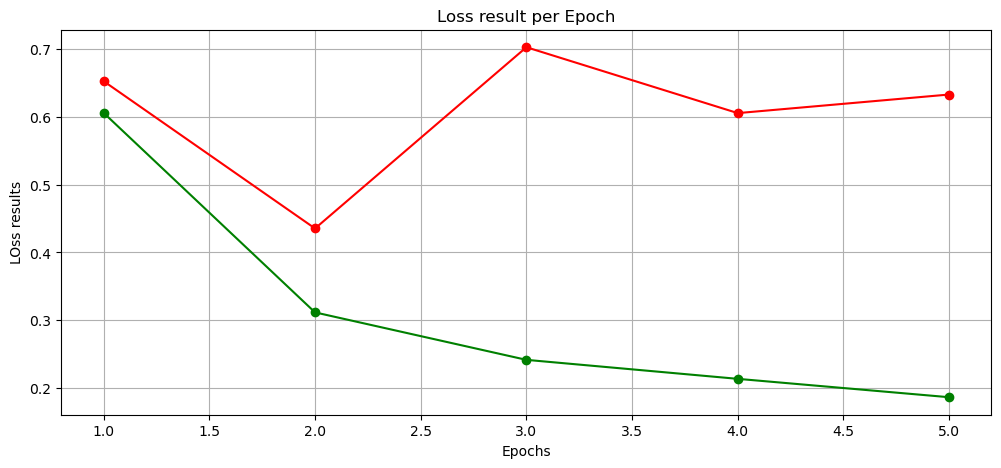

In [18]:
plt.figure(figsize=(12,5))
plt.title('Loss result per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss results')
plt.plot(list(range(1, len(train_losses) + 1)), train_losses, marker='o', color='green')
plt.plot(list(range(1, len(valid_losses) + 1)), valid_losses, marker='o', color='red')
plt.grid(True)
plt.show()

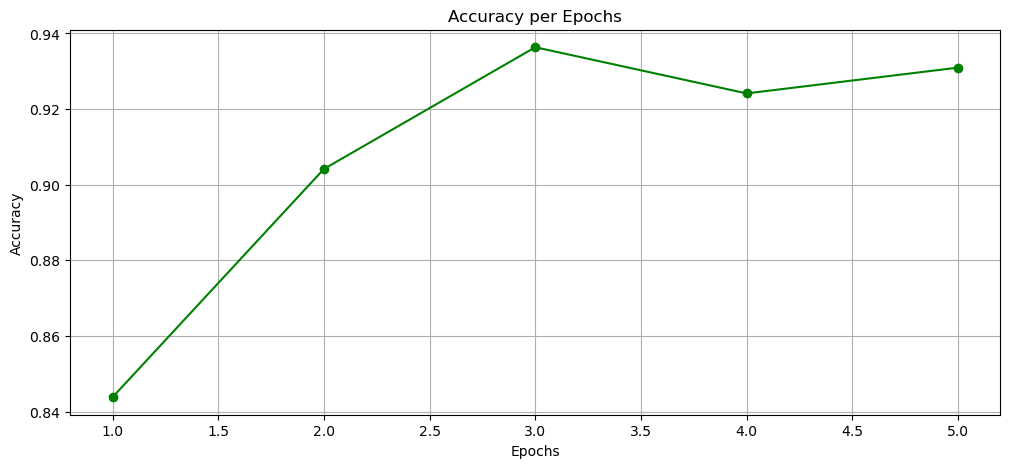

In [19]:
plt.figure(figsize=(12,5))
plt.title('Accuracy per Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(list(range(1, len(valid_accuracies) + 1)), valid_accuracies, marker='o', color='green')
plt.grid(True)
plt.show()

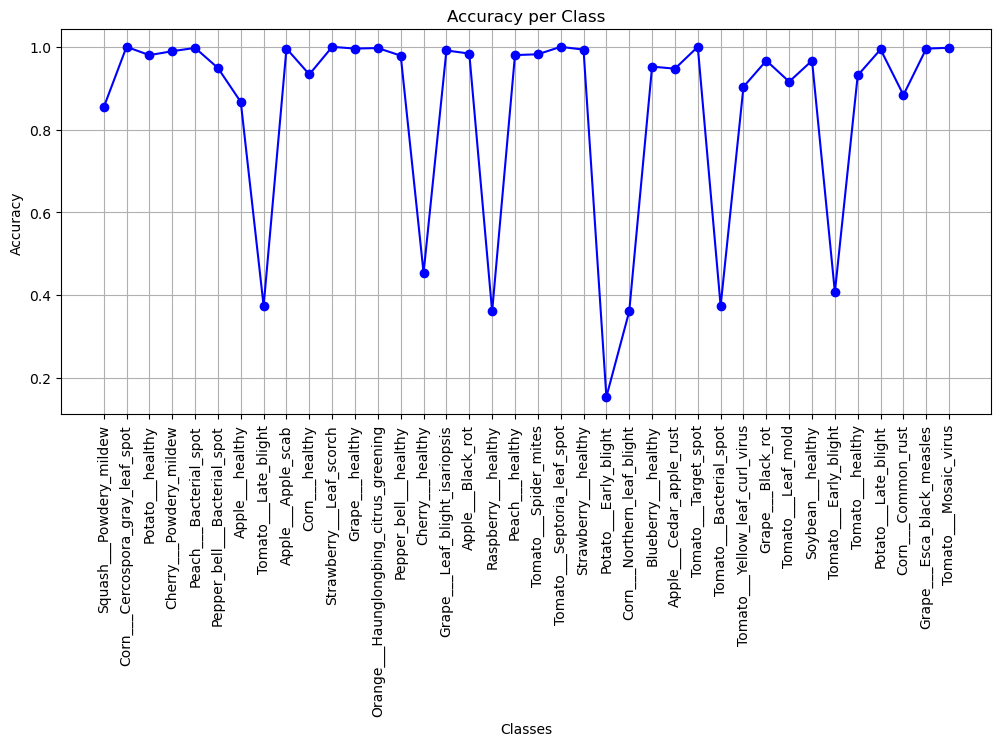

In [20]:
plt.figure(figsize=(12,5))
plt.title('Accuracy per Class')
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.plot(label_per_class, accuracy_per_class, marker='o', color='blue')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [23]:
print(f"Accuracy of the test set : {accuracy_final:.3f}")

Accuracy of the test set : 0.931


In [24]:
print(f"Precision score : {precision:.3f}")

Precision score : 0.945


In [25]:
print(f"Recall score : {recall:.3f}")

Recall score : 0.931


In [26]:
print(f"F1 score : {f1:.3f}")

F1 score : 0.929
